In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
import seaborn as sns
from collections import Counter
import Augmentor
from sklearn.metrics import confusion_matrix
np.random.seed(42)

2023-01-04 11:07:41.194128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 11:07:41.968847: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teresababio/miniconda3/envs/core/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-04 11:07:41.968888: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-04 11:07:45.172381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnv

# Funciones

In [2]:
#Funcion que permite leer el conjunto test
def lectura_test(data_dir):
    test = pd.read_csv(data_dir + '/Test.csv')

    labels = test["ClassId"].values
    imgs = test["Path"].values

    data =[]
    for img in imgs:
        try:

            image = cv2.imread(data_dir + '/' +img)
            image = np.asarray(Image.open(data_dir + '/' +img))
            img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            data.append(img) 

        except:
            print("Error in " + img)

    X_test = np.array(data)
    X_test = X_test/255
    return X_test, labels


In [3]:
#Funcion que divide el conjunto train en un de entrenamiento y validación
def split(image_data, image_labels,div=0.3):
    X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=div, random_state=42, shuffle=True)

    X_train = X_train/255 
    X_val = X_val/255
    y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
    y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)
    
    print("X_train.shape", X_train.shape)
    print("X_valid.shape", X_val.shape)
    print("y_train.shape", y_train.shape)
    print("y_valid.shape", y_val.shape)
    return X_train, X_val, y_train, y_val

In [4]:
#lista de callbacks
def callbacks(list_include,min_delta=0.0001, patience = 5, name_check=None, name_csv=None):
    
    list_callbacks = []
    if list_include[0]:
        Stoppincallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                min_delta= min_delta, 
                                patience= patience, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)
        list_callbacks.append(Stoppincallback)

    if list_include[1]:
        Checkpointcallback = tf.keras.callbacks.ModelCheckpoint(name_check, 
                                     monitor='loss', 
                                     verbose=0, 
                                     save_best_only=False,
                                     save_weights_only=False, 
                                     save_freq='epoch')
        list_callbacks.append(Checkpointcallback)
        
    if list_include[2]:

        tbCallBack = keras.callbacks.TensorBoard(log_dir="Tensorboard", histogram_freq=0,
                                         write_graph=True, write_images=False)
        
        list_callbacks.append(tbCallBack)
        
    if list_include[3]:
        CSVcallback = tf.keras.callbacks.CSVLogger(name_csv, 
                             separator=',', 
                             append=False)
        list_callbacks.append(CSVcallback)
    print(len(list_callbacks))

    return list_callbacks

In [5]:
#Matriz de confusion

def matriz_confusion(labels, pred):

    value_test = Counter(list(labels))
    res = confusion_matrix(labels,pred)

    for i in range(len(res)):
        print( "label    pred correct     test")
        print(f"  {i}      {res[i][i]}               {value_test[i]}")
        
    plt.figure(0,figsize=(20,20))
    plt.title("Confusion Matrix")
    sns.heatmap(res, annot=True)
    
    
    np.fill_diagonal(res,0 )
    plt.figure(1, figsize=(20,20))
    plt.title("Confusion Matrix")
    sns.heatmap(res, annot=True)
    
    plt.show()

In [6]:
def grafica_accuracy(history):

    plt.figure(0, figsize=(3,3))
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()

    plt.figure(1, figsize=(3,3))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [7]:
#Red neuronal para clasificación 

def model_cnn(n_classes):
    model = Sequential()   
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
#Modelo creaado a partir de MobileNetV3Small

def mobilenet(n_classes):
    print(IMG_HEIGHT,IMG_WIDTH,channels)
    base_model = MobileNetV3Small(weights="imagenet", input_shape=(IMG_HEIGHT,IMG_WIDTH,channels),  include_top=False)

    x= base_model.output
    x= keras.layers.GlobalAveragePooling2D()(x)
    x= keras.layers.Dense(512, activation ='relu')(x)
    x= keras.layers.Dense(256, activation ='relu')(x)
    x= keras.layers.Dense(128, activation ='relu')(x)
    preds = keras.layers.Dense(n_classes, activation ='softmax')(x)

    model = keras.Model(inputs=base_model.input, outputs=preds)



    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Lectura de datos

In [12]:
cur_path = os.getcwd()

data_dir = os.getcwd()
train_path = os.path.join(cur_path,'Train')
test_path = os.path.join(cur_path,'Test')

# Tamaño de imagenes 
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3
data_dir

'/home/teresababio/FinalProject/Proyecto_Final/datos'

In [13]:
NUM_CATEGORIES = len(os.listdir(train_path))
print('Total trainable classes: ',NUM_CATEGORIES)

Total trainable classes:  43


In [14]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = np.asarray(Image.open(path + '/' + img))
            img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image_data.append(img)
            image_labels.append(i)
        except:
            print("Error in " + img+ " "+ str(i))
list_data = image_data
list_labels = image_labels
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

Error in output 0
Error in output 6
Error in output 14
Error in output 15
Error in output 16
Error in output 19
Error in output 20
Error in output 21
Error in output 22
Error in output 23
Error in output 24
Error in output 26
Error in output 27
Error in output 28
Error in output 29
Error in output 30
Error in output 31
Error in output 32
Error in output 33
Error in output 34
Error in output 36
Error in output 37
Error in output 39
Error in output 40
Error in output 41
Error in output 42
(39209, 30, 30, 3) (39209,)


In [12]:
#conjunto test 
X_test, labels = lectura_test(data_dir)
X_test.shape

(12630, 30, 30, 3)

# RED NEURONAL CNN 

In [13]:
X_train, X_val, y_train, y_val = split(image_data, image_labels)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446, 43)
y_valid.shape (11763, 43)


In [14]:
model = model_cnn(NUM_CATEGORIES)

2023-01-03 16:50:36.114407: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teresababio/miniconda3/envs/core/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-03 16:50:36.114571: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 16:50:36.114652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-FNGN17J8): /proc/driver/nvidia/version does not exist
2023-01-03 16:50:36.115390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow wit

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

In [16]:
#callbacks
list_include = [0, 1, 1, 1]
list_callbacks = callbacks(list_include, name_check="modelos/model_cnn.h5", name_csv="parametros_modelos/model_cnn_csv.csv")


3


In [17]:
epochs = 50
history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_val, y_val),
                    callbacks = list_callbacks)

2023-01-03 16:50:37.631343: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 296416800 exceeds 10% of free system memory.


Epoch 1/50
429/429 [==============================] - 114s 256ms/step - loss: 2.3162 - accuracy: 0.3541 - val_loss: 0.7183 - val_accuracy: 0.8006
Epoch 2/50
429/429 [==============================] - 95s 221ms/step - loss: 0.6852 - accuracy: 0.7866 - val_loss: 0.2054 - val_accuracy: 0.9419
Epoch 3/50
429/429 [==============================] - 93s 216ms/step - loss: 0.3659 - accuracy: 0.8850 - val_loss: 0.1069 - val_accuracy: 0.9717
Epoch 4/50
429/429 [==============================] - 101s 235ms/step - loss: 0.2651 - accuracy: 0.9205 - val_loss: 0.0872 - val_accuracy: 0.9748
Epoch 5/50
429/429 [==============================] - 118s 276ms/step - loss: 0.1965 - accuracy: 0.9403 - val_loss: 0.0644 - val_accuracy: 0.9836
Epoch 6/50
429/429 [==============================] - 116s 271ms/step - loss: 0.1671 - accuracy: 0.9516 - val_loss: 0.0739 - val_accuracy: 0.9774
Epoch 7/50
429/429 [==============================] - 137s 320ms/step - loss: 0.1421 - accuracy: 0.9581 - val_loss: 0.0532 - v

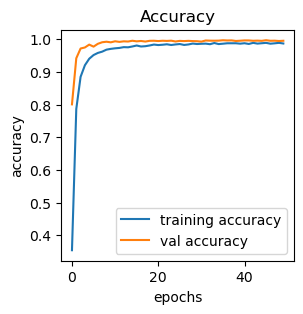

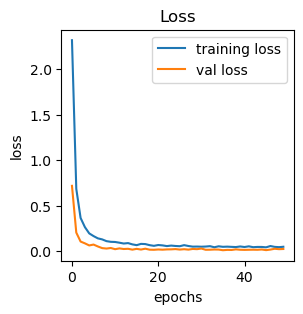

In [18]:
grafica_accuracy(history)

In [19]:
#guardamos el modelo
model.save("modelos_finales/model_cnn.h5")
model.save_weights("model_cnn_weights.h5")

In [20]:
#Conjunto test

pred = model.predict(X_test) 
pred = np.argmax(pred, axis=1)


print('\nTest Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 14s 32ms/step

Test Data accuracy:  97.5217735550277


label    pred correct     test
  0      60               60
label    pred correct     test
  1      713               720
label    pred correct     test
  2      736               750
label    pred correct     test
  3      433               450
label    pred correct     test
  4      638               660
label    pred correct     test
  5      614               630
label    pred correct     test
  6      142               150
label    pred correct     test
  7      443               450
label    pred correct     test
  8      430               450
label    pred correct     test
  9      480               480
label    pred correct     test
  10      652               660
label    pred correct     test
  11      413               420
label    pred correct     test
  12      675               690
label    pred correct     test
  13      717               720
label    pred correct     test
  14      270               270
label    pred correct     test
  15      209               210
labe

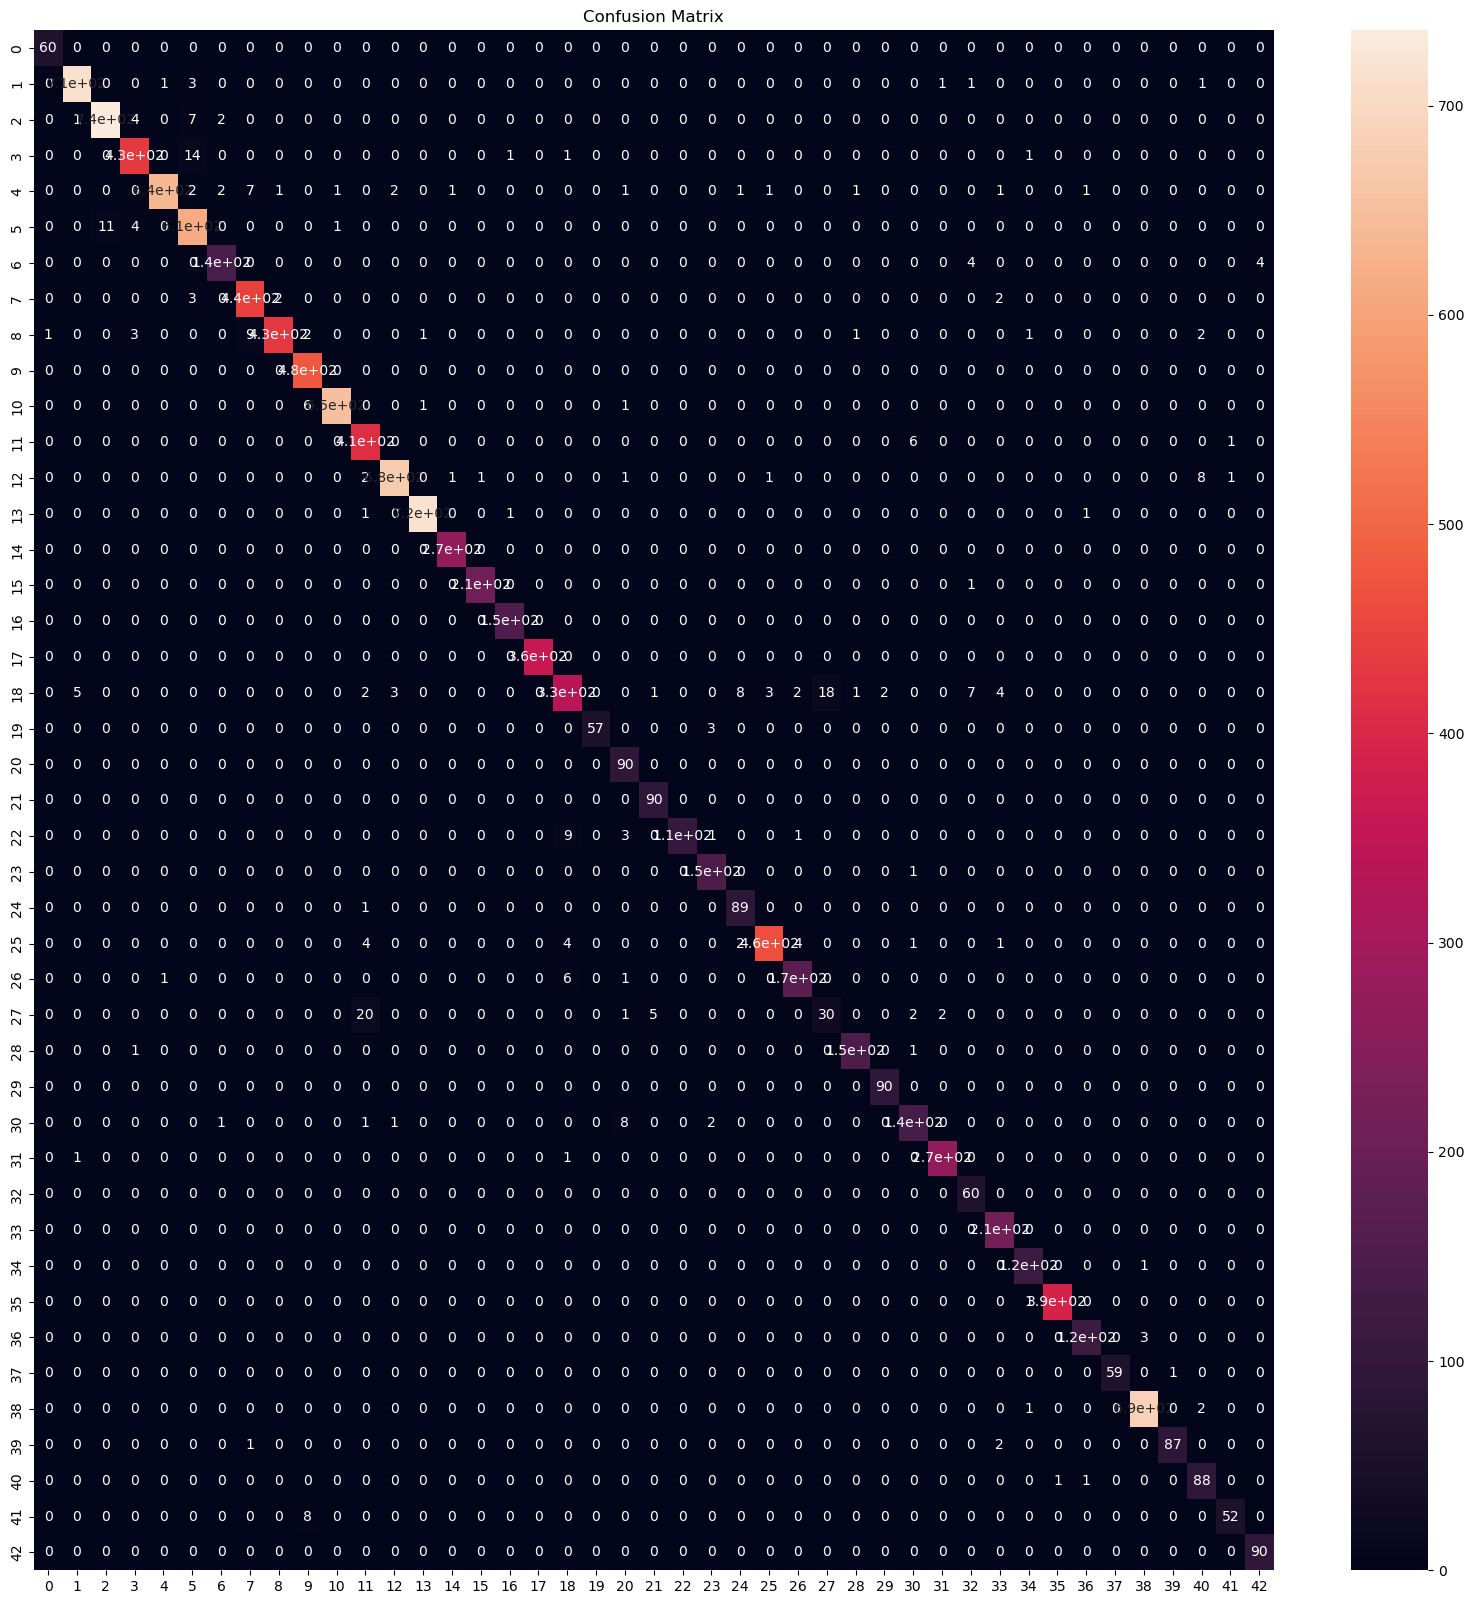

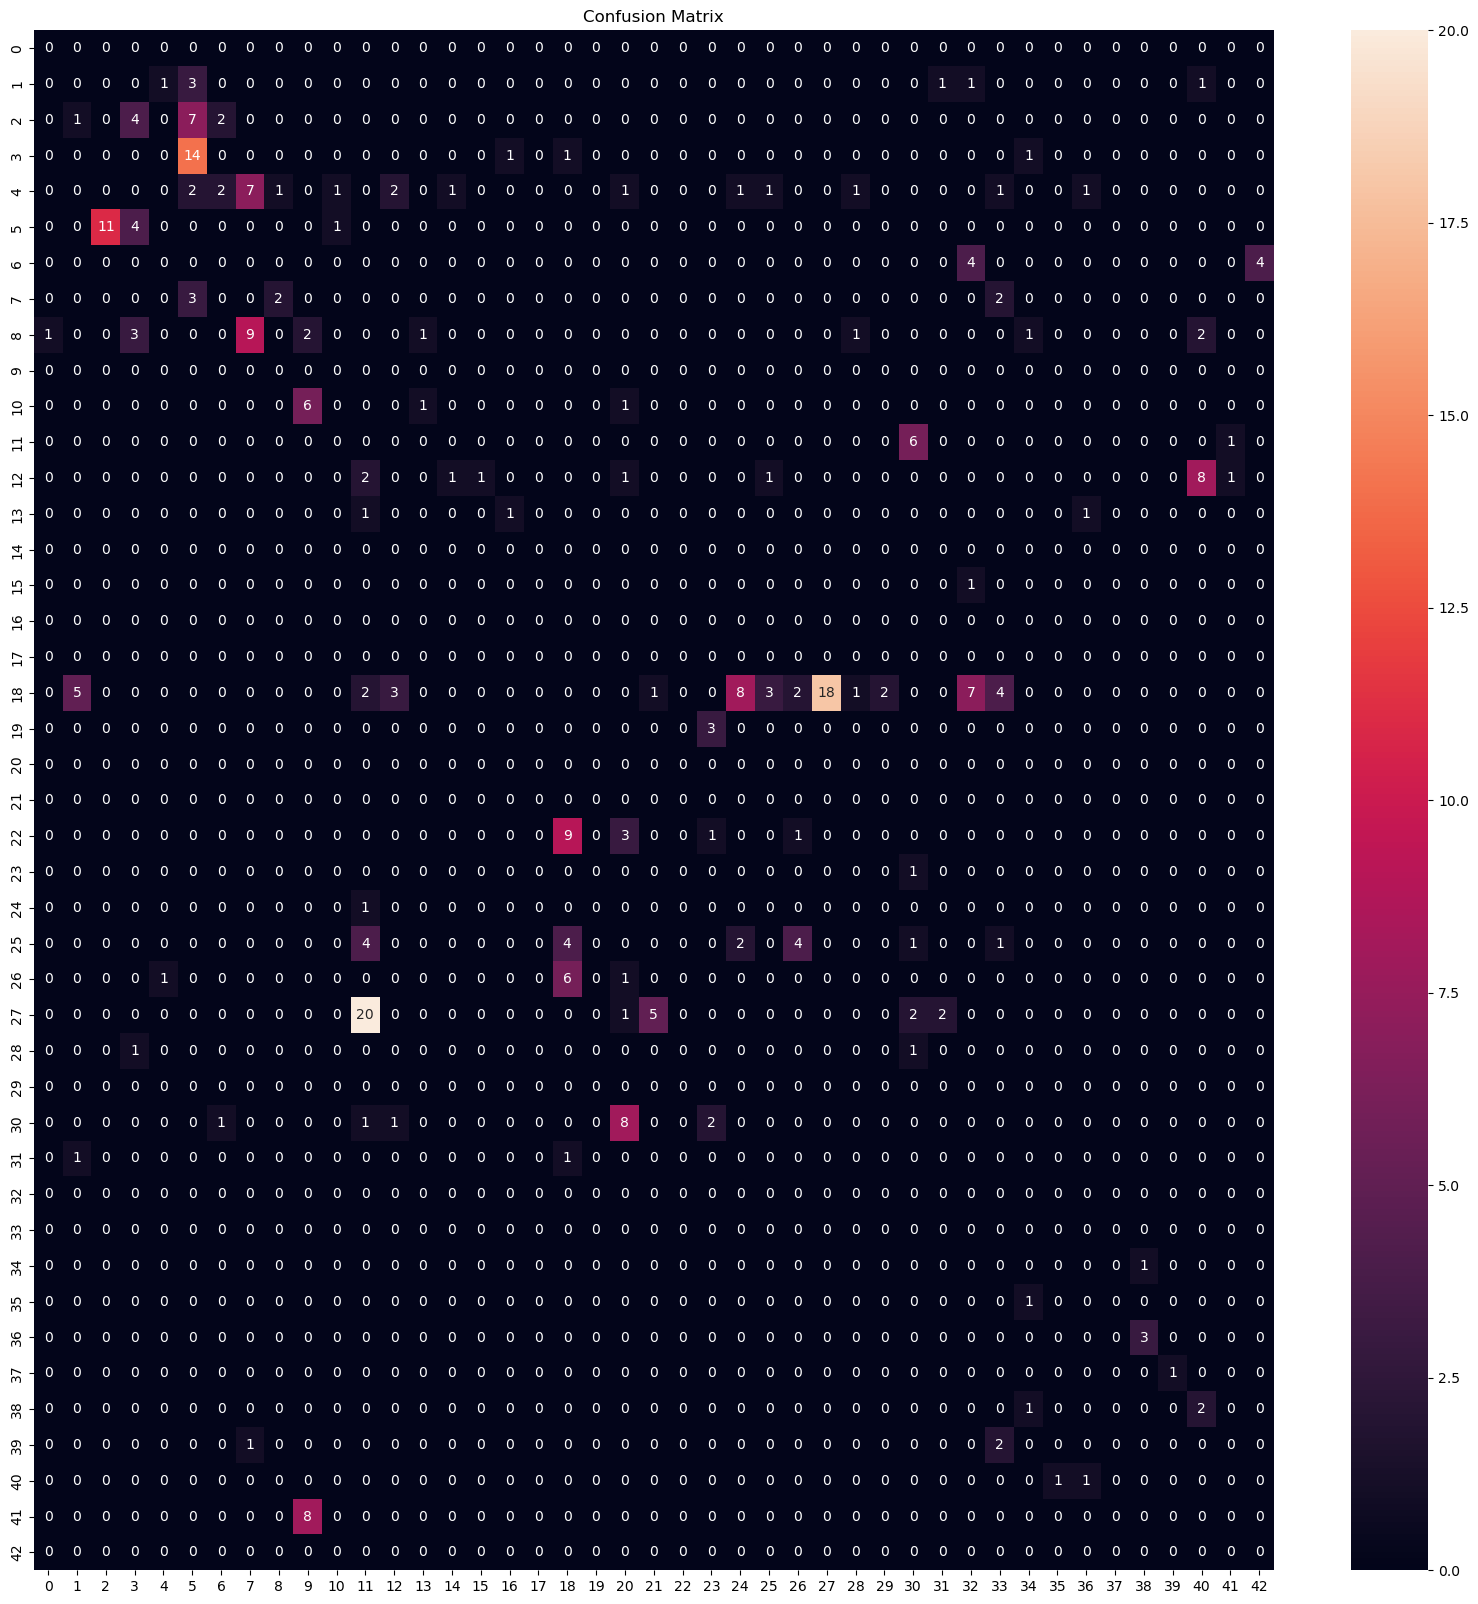

In [21]:
matriz_confusion(labels, pred)

# RED NEURONAL CNN CON DATA AUGMENTATION

In [13]:
count_train = Counter(list(image_labels))

In [14]:
list(zip(count_train.keys(), count_train.values()))

[(0, 210),
 (1, 2220),
 (2, 2250),
 (3, 1410),
 (4, 1980),
 (5, 1860),
 (6, 420),
 (7, 1440),
 (8, 1410),
 (9, 1470),
 (10, 2010),
 (11, 1320),
 (12, 2100),
 (13, 2160),
 (14, 780),
 (15, 630),
 (16, 420),
 (17, 1110),
 (18, 1200),
 (19, 210),
 (20, 360),
 (21, 330),
 (22, 390),
 (23, 510),
 (24, 270),
 (25, 1500),
 (26, 600),
 (27, 240),
 (28, 540),
 (29, 270),
 (30, 450),
 (31, 780),
 (32, 240),
 (33, 689),
 (34, 420),
 (35, 1200),
 (36, 390),
 (37, 210),
 (38, 2070),
 (39, 300),
 (40, 360),
 (41, 240),
 (42, 240)]

In [15]:
image_data_aug = []
image_labels_aug = []
limit = 1000
for label,value in zip(count_train.keys(), count_train.values()) :
    
    if limit > value:
        print(label, value)
        path = os.path.join(cur_path,'Train',str(label), 'output')
        if not os.path.exists(path):
            print("Creacion de carpeta output")
            p = Augmentor.Pipeline(os.path.join(cur_path,'Train',str(label)))
            p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
            p.zoom(probability=0.5, min_factor=1.1, max_factor=1.4)
            p.skew(probability=0.6)
            p.sample(limit - value)  
        
        images = os.listdir(path)
        for img in images:
            try:
                image = np.asarray(Image.open(path + '/' + img))
                img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
                image_data_aug.append(img)
                image_labels_aug.append(label)
            except:
                print("Error in " + img)
                
image_data_aug = np.array(list_data + image_data_aug)
image_labels_aug = np.array(list_labels + image_labels_aug)     

print(image_data_aug.shape, image_labels_aug.shape)

0 210
6 420
14 780
15 630
16 420
19 210
20 360
21 330
22 390
23 510
24 270
26 600
27 240
28 540
29 270
30 450
31 780
32 240
33 689
34 420
36 390
37 210
39 300
40 360
41 240
42 240
(54710, 30, 30, 3) (54710,)


In [16]:
Counter(list(image_labels_aug))

Counter({0: 1000,
         1: 2220,
         2: 2250,
         3: 1410,
         4: 1980,
         5: 1860,
         6: 1000,
         7: 1440,
         8: 1410,
         9: 1470,
         10: 2010,
         11: 1320,
         12: 2100,
         13: 2160,
         14: 1000,
         15: 1000,
         16: 1000,
         17: 1110,
         18: 1200,
         19: 1000,
         20: 1000,
         21: 1000,
         22: 1000,
         23: 1000,
         24: 1000,
         25: 1500,
         26: 1000,
         27: 1000,
         28: 1000,
         29: 1000,
         30: 1000,
         31: 1000,
         32: 1000,
         33: 1000,
         34: 1000,
         35: 1200,
         36: 1000,
         37: 1000,
         38: 2070,
         39: 1000,
         40: 1000,
         41: 1000,
         42: 1000})

In [17]:
X_train, X_val, y_train, y_val = split(image_data_aug, image_labels_aug)

X_train.shape (38297, 30, 30, 3)
X_valid.shape (16413, 30, 30, 3)
y_train.shape (38297, 43)
y_valid.shape (16413, 43)


In [18]:
model = model_cnn(NUM_CATEGORIES)

2023-01-04 07:56:29.490292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teresababio/miniconda3/envs/core/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-04 07:56:29.504291: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-04 07:56:29.506553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-FNGN17J8): /proc/driver/nvidia/version does not exist
2023-01-04 07:56:29.543017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow wit

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

In [20]:
#callbacks
list_include = [0, 1, 1, 1]
list_callbacks = callbacks(list_include, name_check="modelos/model_cnn_aug.h5", name_csv="parametros_modelos/model_cnn_aug_csv.csv")

3


In [21]:
epochs = 50
history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_val, y_val),
                    callbacks = list_callbacks)

2023-01-04 07:56:50.240632: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 413607600 exceeds 10% of free system memory.


Epoch 1/50


2023-01-04 07:57:02.873115: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 13095936 exceeds 10% of free system memory.
2023-01-04 07:57:02.873260: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 13095936 exceeds 10% of free system memory.
2023-01-04 07:57:02.890379: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 15676416 exceeds 10% of free system memory.
2023-01-04 07:57:02.890555: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 15676416 exceeds 10% of free system memory.


599/599 [==============================] - 189s 307ms/step - loss: 2.5793 - accuracy: 0.2800 - val_loss: 1.0516 - val_accuracy: 0.7105
Epoch 2/50
599/599 [==============================] - 134s 224ms/step - loss: 1.0227 - accuracy: 0.6889 - val_loss: 0.5116 - val_accuracy: 0.8462
Epoch 3/50
599/599 [==============================] - 126s 211ms/step - loss: 0.6655 - accuracy: 0.7987 - val_loss: 0.3242 - val_accuracy: 0.9064
Epoch 4/50
599/599 [==============================] - 126s 210ms/step - loss: 0.5185 - accuracy: 0.8451 - val_loss: 0.2705 - val_accuracy: 0.9210
Epoch 5/50
599/599 [==============================] - 125s 208ms/step - loss: 0.4285 - accuracy: 0.8714 - val_loss: 0.2121 - val_accuracy: 0.9391
Epoch 6/50
599/599 [==============================] - 126s 211ms/step - loss: 0.3706 - accuracy: 0.8895 - val_loss: 0.1922 - val_accuracy: 0.9452
Epoch 7/50
599/599 [==============================] - 128s 214ms/step - loss: 0.3268 - accuracy: 0.9025 - val_loss: 0.1745 - val_accura

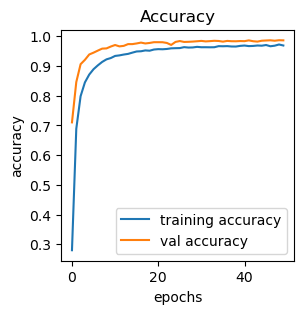

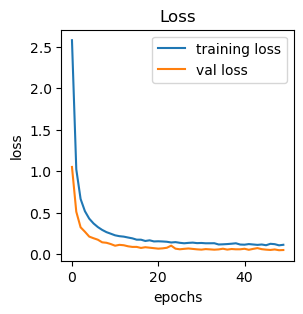

In [22]:
grafica_accuracy(history)

In [23]:
#probamos en el conjunto test

pred = model.predict(X_test) 
pred = np.argmax(pred, axis=1)

print('\nTest Data accuracy: ', accuracy_score(labels, pred)*100)

395/395 [==============================] - 12s 27ms/step

Test Data accuracy:  97.37925574030088


In [24]:
#guardamos el modelo
model.save("modelos_finales/model_cnn_aug.h5")
model.save_weights("model_cnn_aug_weights.h5")

label    pred correct     test
  0      60               60
label    pred correct     test
  1      717               720
label    pred correct     test
  2      744               750
label    pred correct     test
  3      421               450
label    pred correct     test
  4      645               660
label    pred correct     test
  5      618               630
label    pred correct     test
  6      145               150
label    pred correct     test
  7      448               450
label    pred correct     test
  8      431               450
label    pred correct     test
  9      480               480
label    pred correct     test
  10      655               660
label    pred correct     test
  11      388               420
label    pred correct     test
  12      672               690
label    pred correct     test
  13      712               720
label    pred correct     test
  14      270               270
label    pred correct     test
  15      209               210
labe

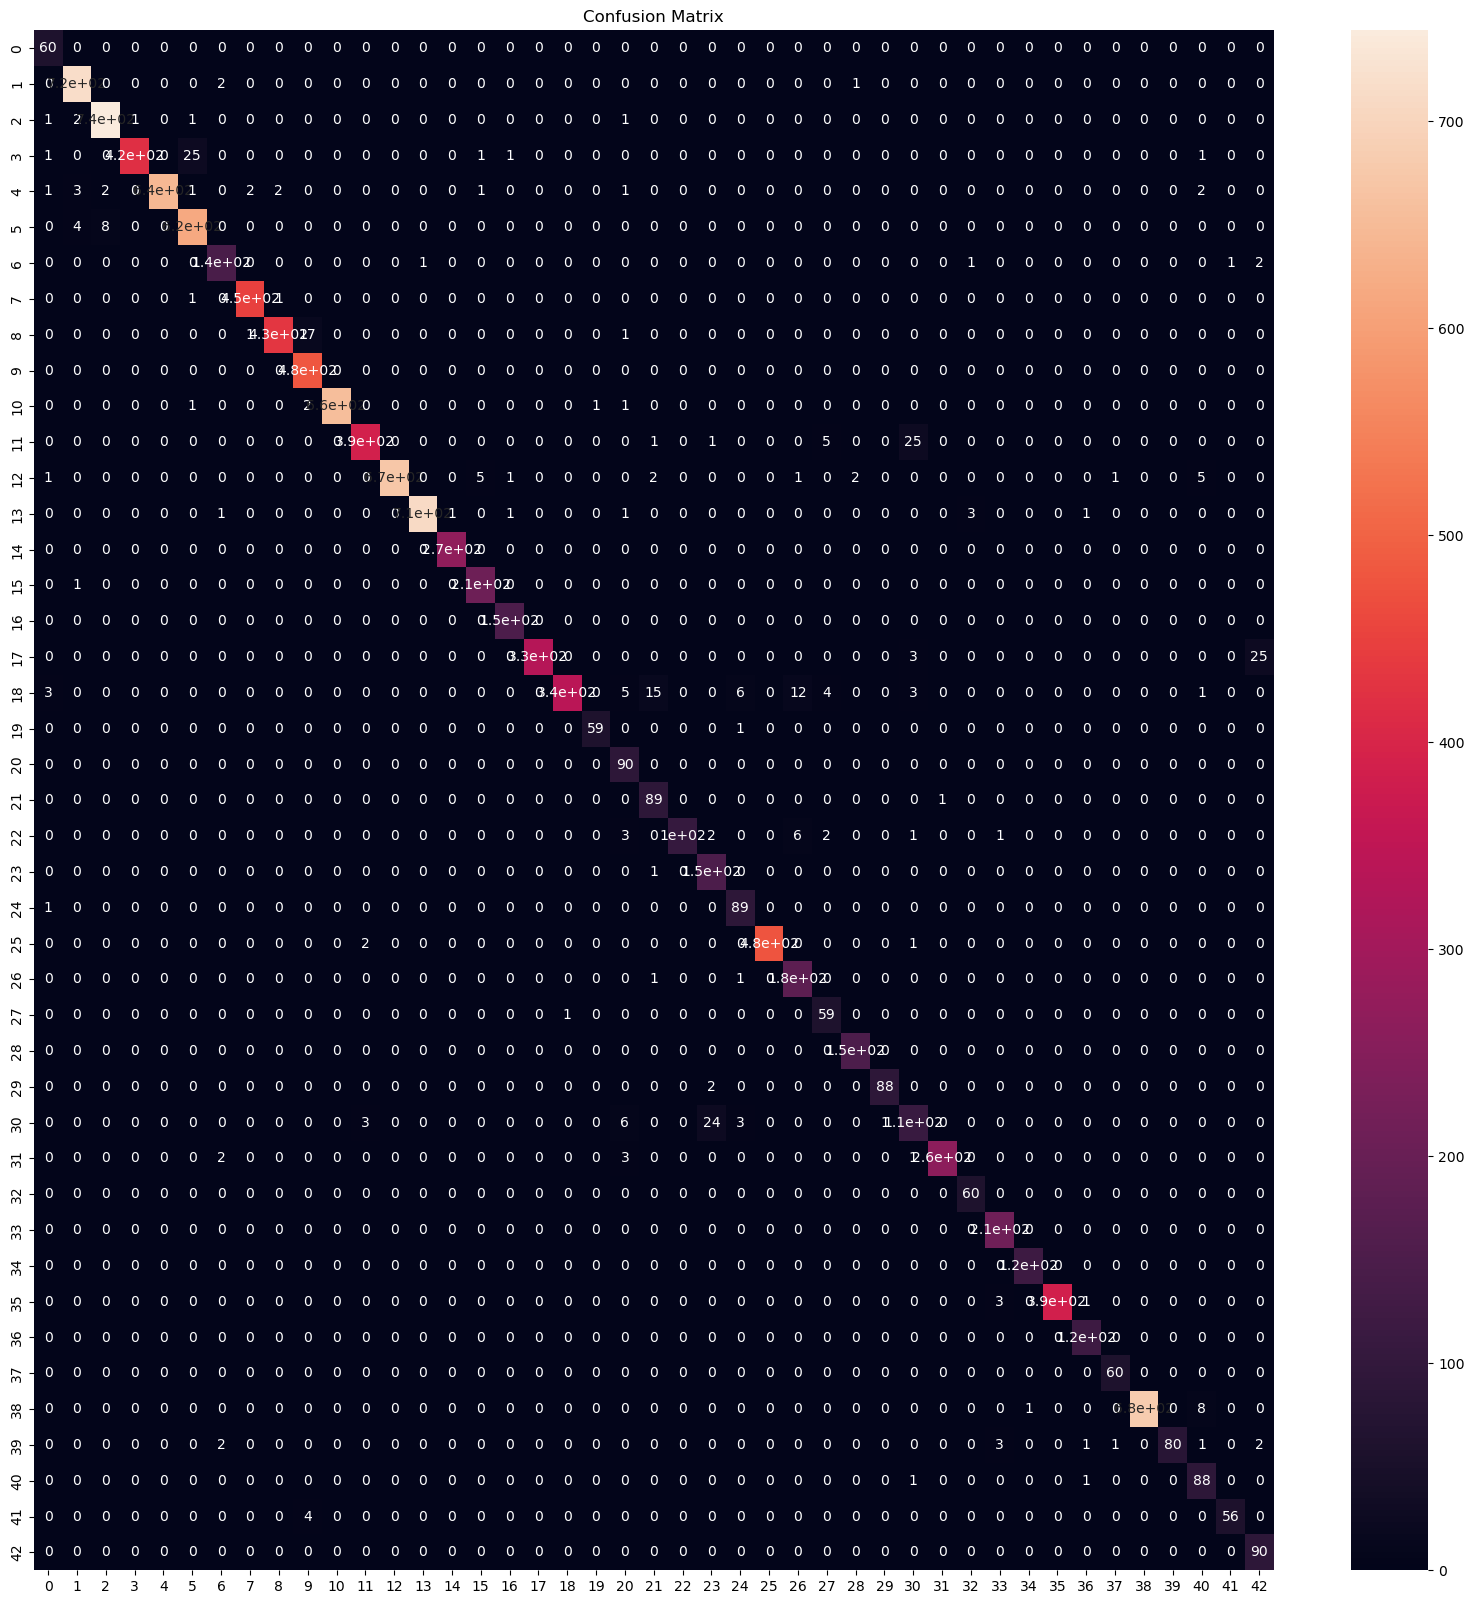

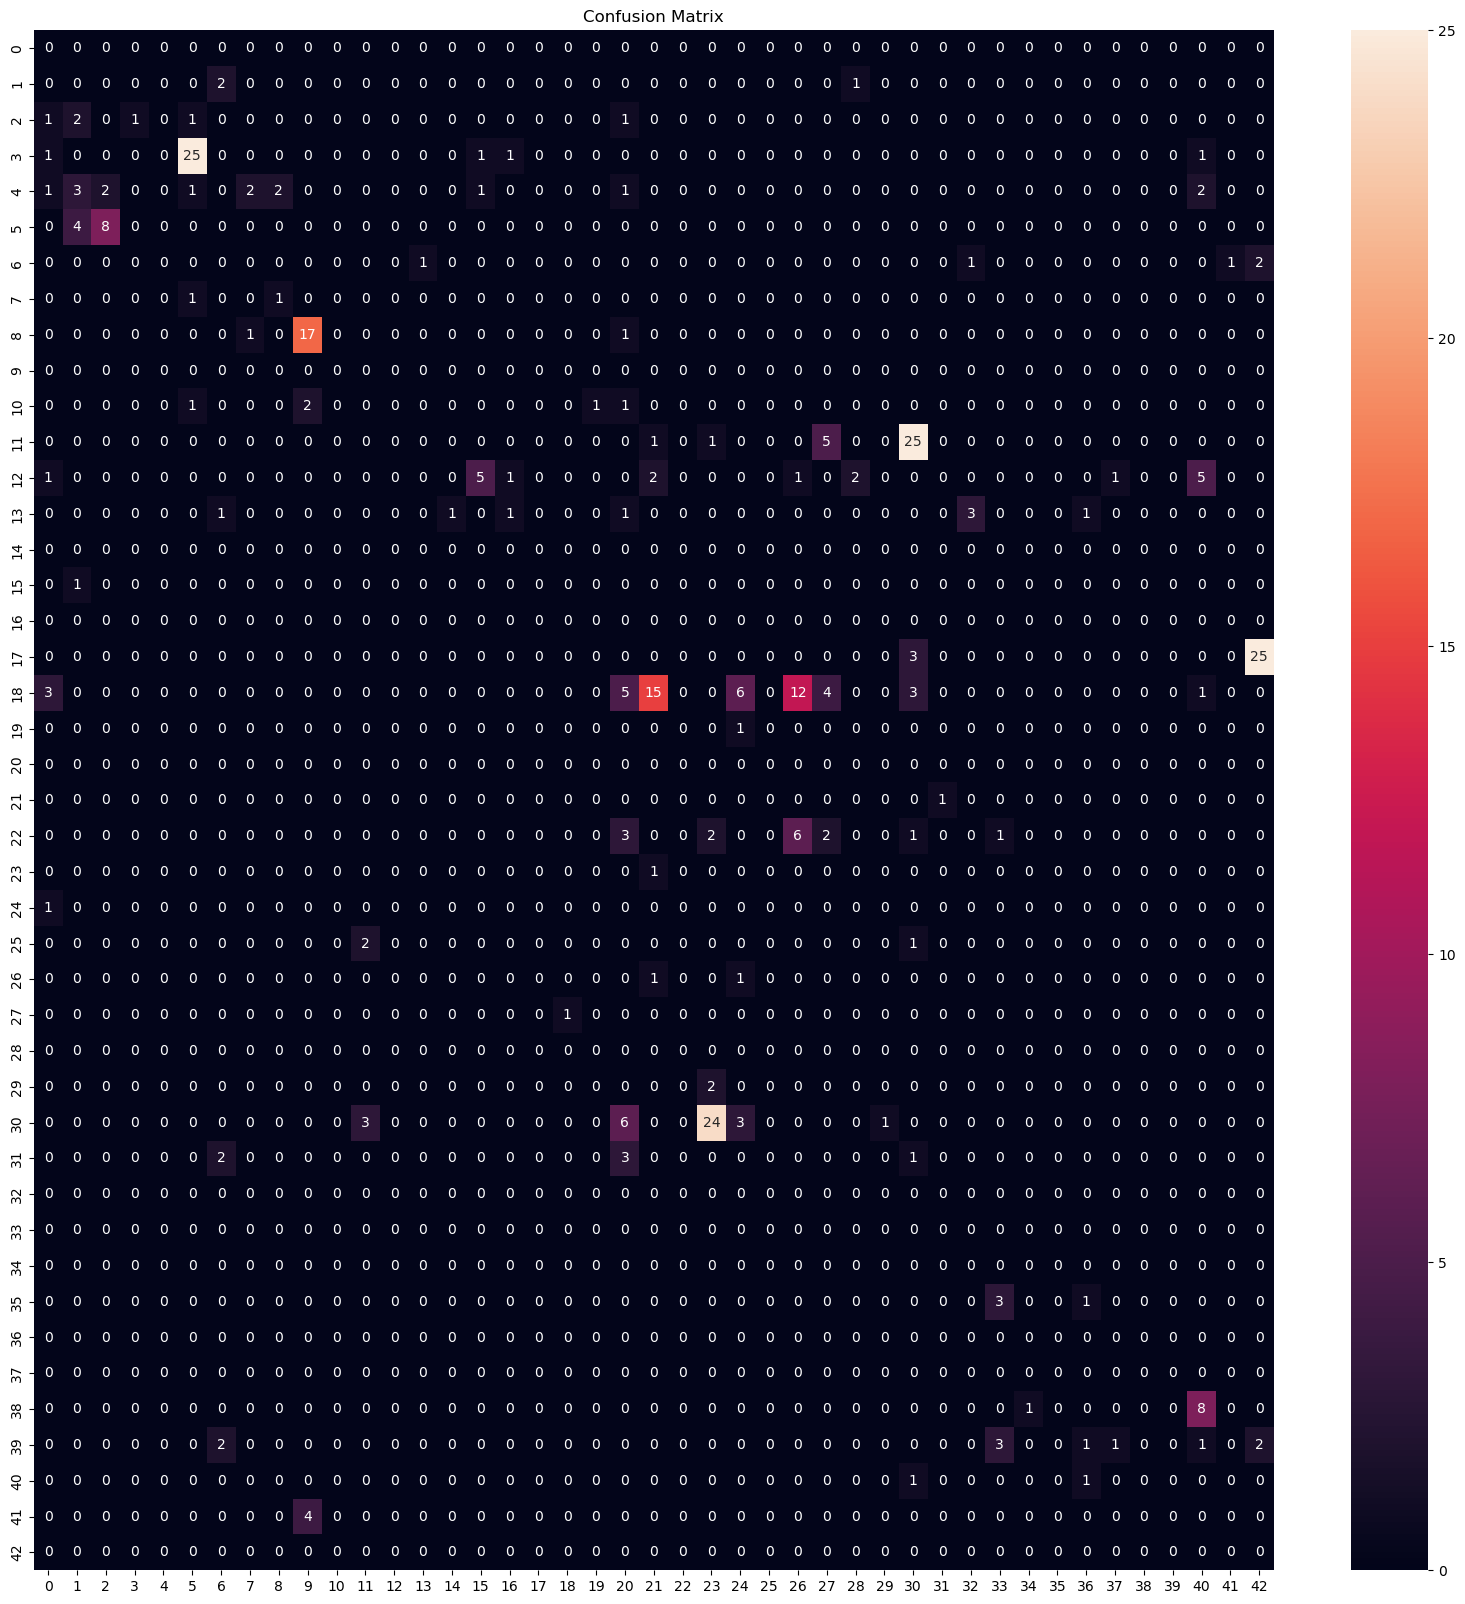

In [25]:
#Matriz de confusion
matriz_confusion(labels, pred)

# Mobilenet v3

In [15]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [16]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = np.asarray(Image.open(path + '/' + img))
            img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image_data.append(img)
            image_labels.append(i)
        except:
            print("Error in " + img+ " "+ str(i))
list_data = image_data
list_labels = image_labels
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

Error in output 0
Error in output 6
Error in output 14
Error in output 15
Error in output 16
Error in output 19
Error in output 20
Error in output 21
Error in output 22
Error in output 23
Error in output 24
Error in output 26
Error in output 27
Error in output 28
Error in output 29
Error in output 30
Error in output 31
Error in output 32
Error in output 33
Error in output 34
Error in output 36
Error in output 37
Error in output 39
Error in output 40
Error in output 41
Error in output 42
(39209, 32, 32, 3) (39209,)


In [18]:
X_train, X_val, y_train, y_val = split(image_data, image_labels)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446, 43)
y_valid.shape (11763, 43)


In [19]:
from tensorflow.keras.applications import MobileNetV3Small

In [22]:
model = mobilenet(NUM_CATEGORIES)

32 32 3


In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 16, 16, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 16, 16, 16)  64          ['Conv[0][0]']                   
 tion)                                                                                      

 re_lu_36 (ReLU)                (None, 4, 4, 72)     0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 4, 4, 24)    1728        ['re_lu_36[0][0]']               
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 4, 4, 24)    96          ['expanded_conv_1/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_2/expand (Conv2D  (None, 4, 4, 88)    2112        ['expanded_conv_1/project/BatchNo
 )        

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_31 (TFOpL  (None, 1, 1, 96)    0           ['expanded_conv_3/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
                                                                                                  
 re_lu_41 

                                                                                                  
 expanded_conv_4/project (Conv2  (None, 2, 2, 40)    9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 2, 2, 40)    160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_4/Add (Add)      (None, 2, 2, 40)     0           ['expanded_conv_3/project/BatchNo
                                                                 rm[0][0]',                       
                                                                  'expanded_conv_4/project/BatchNo
          

 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 2, 2, 120)   480         ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_38 (TFOpL  (None, 2, 2, 120)   0           ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
                                                                                                  
 re_lu_48 (ReLU)                (None, 2, 2, 120)    0           ['tf.__operators__.add_38[0][0]']
                                                                                                  
 tf.math.m

 expanded_conv_7/depthwise (Dep  (None, 2, 2, 144)   3600        ['multiply_27[0][0]']            
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 2, 2, 144)   576         ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_42 (TFOpL  (None, 2, 2, 144)   0           ['expanded_conv_7/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_52 (ReLU)                (None, 2, 2, 144)    0           ['tf.__operators__.add_42[0][0]']
          

 re_lu_55 (ReLU)                (None, 1, 1, 288)    0           ['tf.__operators__.add_45[0][0]']
                                                                                                  
 tf.math.multiply_45 (TFOpLambd  (None, 1, 1, 288)   0           ['re_lu_55[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_30 (Multiply)         (None, 1, 1, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_45[0][0]']    
                                                                                                  
 expanded_conv_8/squeeze_excite  (None, 1, 1, 288)   0           ['multiply_30[0][0]']            
 /AvgPool 

 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_49 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
                                                                                                  
 re_lu_59 (ReLU)                (None, 1, 1, 576)    0           ['tf.__operators__.add_49[0][0]']
                                                                                                  
 tf.math.m

                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 1, 1, 576)   0           ['multiply_34[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_52[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 1, 1, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 1, 1, 96)    384         ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_

In [26]:
#callbacks
list_include = [0, 1, 1, 1]
list_callbacks = callbacks(list_include, name_check="modelos/model_mobile.h5", name_csv="parametros_modelos/model_mobile_csv.csv")

3


In [27]:
epochs = 50
history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_val, y_val),
                    callbacks = list_callbacks)

2023-01-04 11:15:15.290162: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 337256448 exceeds 10% of free system memory.


Epoch 1/50
429/429 [==============================] - 106s 242ms/step - loss: 0.4855 - accuracy: 0.8453 - val_loss: 4.6021 - val_accuracy: 0.0486
Epoch 2/50
429/429 [==============================] - 53s 124ms/step - loss: 0.3785 - accuracy: 0.8787 - val_loss: 5.7065 - val_accuracy: 0.0356
Epoch 3/50
429/429 [==============================] - 50s 115ms/step - loss: 0.2956 - accuracy: 0.9049 - val_loss: 6.0099 - val_accuracy: 0.0468
Epoch 4/50
429/429 [==============================] - 53s 124ms/step - loss: 0.2773 - accuracy: 0.9123 - val_loss: 4.8167 - val_accuracy: 0.0349
Epoch 5/50
429/429 [==============================] - 51s 119ms/step - loss: 0.2297 - accuracy: 0.9287 - val_loss: 4.2666 - val_accuracy: 0.0563
Epoch 6/50
429/429 [==============================] - 61s 143ms/step - loss: 0.2086 - accuracy: 0.9345 - val_loss: 5.0417 - val_accuracy: 0.0185
Epoch 7/50
429/429 [==============================] - 59s 137ms/step - loss: 0.2027 - accuracy: 0.9377 - val_loss: 10.8684 - val_

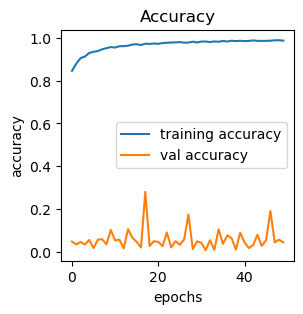

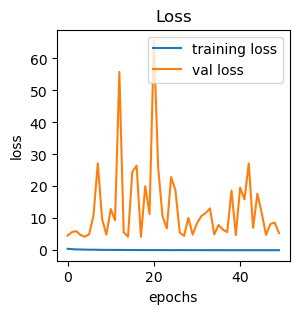

In [28]:
grafica_accuracy(history)

In [ ]:
#conjunto test 
X_test, labels = lectura_test(data_dir)
X_test.shape

In [ ]:
#probamos en el conjunto test

pred = model.predict(X_test) 
pred = np.argmax(pred, axis=1)

print('\nTest Data accuracy: ', accuracy_score(labels, pred)*100)

In [ ]:
#guardamos el modelo
model.save("modelos_finales/model_mobilre.h5")
model.save_weights("model_mobile_weights.h5")

In [ ]:
#Matriz de confusion
matriz_confusion(labels, pred)